In [17]:
import os
import numpy as np
import pandas as pd
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import pyarrow.parquet as pq
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# File paths
# Dataset 1 
folder_train_path = "Combined_Dataset/train/"
folder_test_path = "Combined_Dataset/test/"
# Dataset 2 
train_parquet_path = "Combined_Dataset_2/train-00000-of-00001-c08a401c53fe5312.parquet"
test_parquet_path = "Combined_Dataset_2/test-00000-of-00001-44110b9df98c5585.parquet"

# Output path for combined dataset
output_dir = "Combined_MRI_Dataset"
os.makedirs(output_dir, exist_ok=True)
os.makedirs(os.path.join(output_dir, "train"), exist_ok=True)
os.makedirs(os.path.join(output_dir, "test"), exist_ok=True)
os.makedirs(os.path.join(output_dir, "val"), exist_ok=True) # Added directory for validation set

# Output path for resampled dataset (new folder)
resampled_output_dir = "Resampled_MRI_Dataset"
os.makedirs(resampled_output_dir, exist_ok=True)
os.makedirs(os.path.join(resampled_output_dir, "train"), exist_ok=True)
os.makedirs(os.path.join(resampled_output_dir, "test"), exist_ok=True)
os.makedirs(os.path.join(resampled_output_dir, "val"), exist_ok=True)

# Settings
img_size = 128  # set 128 for now, might up to 256

# Class mapping
classes = {
    0: 'Mild_Demented',
    1: 'Moderate_Demented',
    2: 'Non_Demented',
    3: 'Very_Mild_Demented'
}

# Create class directories in output directories
for class_name in classes.values():
    # Original dataset directories
    os.makedirs(os.path.join(output_dir, "train", class_name), exist_ok=True)
    os.makedirs(os.path.join(output_dir, "test", class_name), exist_ok=True)
    os.makedirs(os.path.join(output_dir, "val", class_name), exist_ok=True)
    
    # Resampled dataset directories
    os.makedirs(os.path.join(resampled_output_dir, "train", class_name), exist_ok=True)
    os.makedirs(os.path.join(resampled_output_dir, "test", class_name), exist_ok=True)
    os.makedirs(os.path.join(resampled_output_dir, "val", class_name), exist_ok=True)

# LOAD DATASET 1 (FOLDER-BASED)
def load_folder_dataset(base_dir, target_size=(img_size, img_size)):
    dataset = []
    
    # Map folder names to label system
    folder_to_label = {
        "No Impairment": 2,           # Non Demented
        "Very Mild Impairment": 3,    # Very Mild Demented
        "Mild Impairment": 0,         # Mild Demented
        "Moderate Impairment": 1      # Moderate Demented
    }
    
    for folder_name, label in folder_to_label.items():
        folder_path = os.path.join(base_dir, folder_name)
        
        if os.path.exists(folder_path):
            for img_name in os.listdir(folder_path):
                if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                    img_path = os.path.join(folder_path, img_name)
                    try:
                        # Load and convert image to grayscale
                        img = Image.open(img_path).convert('L')
                        
                        # Resize to standard size
                        img = img.resize(target_size)
                        
                        # Convert to numpy array and normalize
                        img_arr = np.array(img) / 255.0
                        
                        # Add to dataset
                        dataset.append({
                            'label': label,
                            'image': img_arr,
                            'source': 'folder_dataset',
                            'original_path': img_path,
                            'class_name': classes[label]
                        })
                        
                    except Exception as e:
                        print(f"Error loading {img_path}: {e}")
        else:
            print(f"Folder not found: {folder_path}")
    
    return dataset

# LOAD DATASET 2 (PARQUET-BASED) 
def bytes_to_image(img_bytes):
    nparr = np.frombuffer(img_bytes, np.uint8)
    img = cv2.imdecode(nparr, cv2.IMREAD_GRAYSCALE)
    return img

def load_parquet_data(file_path):
    dataset = []
    
    try:
        table = pq.read_table(file_path)
        df = table.to_pandas()
        
        for i, row in df.iterrows():
            img_bytes = row['image']['bytes']
            img = bytes_to_image(img_bytes)
            
            # Resize image to standard size
            img_resized = cv2.resize(img, (img_size, img_size))
            
            # Normalize pixel values to [0,1]
            img_normalized = img_resized / 255.0
            
            dataset.append({
                'image': img_normalized,
                'label': row['label'],
                'source': 'parquet_dataset',
                'original_path': f'parquet_dataset_image_{i}',
                'class_name': classes[row['label']]
            })
            
    except Exception as e:
        print(f"Error loading parquet file {file_path}: {e}")
    
    return dataset

# SAVE COMBINED DATASET 
def save_images(data, output_subdir):
    # Count images saved per class
    class_counts = {0: 0, 1: 0, 2: 0, 3: 0}
    
    for i, item in enumerate(data):
        label = item['label']
        img_array = item['image']
        
        # Convert back to 0-255 range for saving
        img_array_255 = (img_array * 255).astype(np.uint8)
        
        # Create PIL image
        img = Image.fromarray(img_array_255)
        
        # Generate filename
        class_name = classes[label]
        class_counts[label] += 1
        
        # Generate unique filename based on source and class count
        source_prefix = 'folder' if item.get('source') == 'folder_dataset' else 'parquet'
        filename = f"{source_prefix}_{class_name}_{class_counts[label]:04d}.png"
        
        # Save path
        save_path = os.path.join(output_dir, output_subdir, class_name, filename)
        
        # Save image
        img.save(save_path)
    
    return class_counts

# Save images to specific directory
def save_images_to_dir(data, output_subdir, base_dir):
    # Count images saved per class
    class_counts = {0: 0, 1: 0, 2: 0, 3: 0}
    
    for i, item in enumerate(data):
        label = item['label']
        img_array = item['image']
        
        # Convert back to 0-255 range for saving
        img_array_255 = (img_array * 255).astype(np.uint8)
        
        # Create PIL image
        img = Image.fromarray(img_array_255)
        
        # Generate filename
        class_name = classes[label]
        class_counts[label] += 1
        
        # Generate unique filename based on source and class count
        source_prefix = 'folder' if item.get('source') == 'folder_dataset' else 'parquet'
        filename = f"{source_prefix}_{class_name}_{class_counts[label]:04d}.png"
        
        # Save path
        save_path = os.path.join(base_dir, output_subdir, class_name, filename)
        
        # Save image
        img.save(save_path)
    
    return class_counts

# Resampling data for balanced datasets
def resampling_data(train_data, test_data):
    all_data = train_data + test_data
    all_data_df = pd.DataFrame(all_data) # converting to pd dataframe cuz stratify only works on columns
    train, test = train_test_split(all_data_df, test_size=0.2, random_state=42, stratify=all_data_df['label'])
    train, val = train_test_split(train, test_size=0.125, random_state=42, stratify=train['label'])
    resampled_train = train.to_dict('records')
    resampled_test = test.to_dict('records')
    resampled_val = val.to_dict('records')
    return resampled_train, resampled_test, resampled_val

def combine_data_pipeline():
    """
    Run the data combination pipeline to merge and resample the datasets
    """
    print("Starting the data combination pipeline...")
    
    # Step 1: Load datasets
    print("\nLoading Dataset 1 (Train)...")
    folder_train_data = load_folder_dataset(folder_train_path)
    print(f"Loaded {len(folder_train_data)} images from Dataset 1 Train")

    print("\nLoading Dataset 1 (Test)...")
    folder_test_data = load_folder_dataset(folder_test_path)
    print(f"Loaded {len(folder_test_data)} images from Dataset 1 Test")

    print("\nLoading Dataset 2 (Train)...")
    parquet_train_data = load_parquet_data(train_parquet_path)
    print(f"Loaded {len(parquet_train_data)} images from Dataset 2 Train")

    print("\nLoading Dataset 2 (Test)...")
    parquet_test_data = load_parquet_data(test_parquet_path)
    print(f"Loaded {len(parquet_test_data)} images from Dataset 2 Test")

    # Step 2: Combine datasets
    combined_train_data = folder_train_data + parquet_train_data
    combined_test_data = folder_test_data + parquet_test_data
    print(f"Combined training data: {len(combined_train_data)} images")
    print(f"Combined test data: {len(combined_test_data)} images")
    
    # Save original combined datasets
    print("\nSaving original combined datasets...")
    train_counts = save_images(combined_train_data, "train")
    test_counts = save_images(combined_test_data, "test")
    print("Original combined datasets saved.")

    # Step 3: Resample data for balance
    print("\nResampling data for balanced dataset...")
    resampled_train_data, resampled_test_data, resampled_val_data = resampling_data(combined_train_data, combined_test_data)
    print(f"Resampled training data: {len(resampled_train_data)} images")
    print(f"Resampled test data: {len(resampled_test_data)} images")
    print(f"Resampled validation data: {len(resampled_val_data)} images")

    # Step 4: Save resampled data
    print("\nSaving resampled data...")
    save_images_to_dir(resampled_train_data, "train", resampled_output_dir)
    save_images_to_dir(resampled_test_data, "test", resampled_output_dir)
    save_images_to_dir(resampled_val_data, "val", resampled_output_dir)
    
    print("\nData combination complete!")
    print(f"Original combined data saved in {output_dir}")
    print(f"Resampled data saved in {resampled_output_dir}")
    
    return resampled_train_data, resampled_test_data, resampled_val_data

if __name__ == "__main__":
    combine_data_pipeline()

Starting the data combination pipeline...

Loading Dataset 1 (Train)...
Loaded 10240 images from Dataset 1 Train

Loading Dataset 1 (Test)...
Loaded 1279 images from Dataset 1 Test

Loading Dataset 2 (Train)...
Error loading parquet file Combined_Dataset_2/train-00000-of-00001-c08a401c53fe5312.parquet: Combined_Dataset_2/train-00000-of-00001-c08a401c53fe5312.parquet
Loaded 0 images from Dataset 2 Train

Loading Dataset 2 (Test)...
Error loading parquet file Combined_Dataset_2/test-00000-of-00001-44110b9df98c5585.parquet: Combined_Dataset_2/test-00000-of-00001-44110b9df98c5585.parquet
Loaded 0 images from Dataset 2 Test
Combined training data: 10240 images
Combined test data: 1279 images

Saving original combined datasets...
Original combined datasets saved.

Resampling data for balanced dataset...
Resampled training data: 8063 images
Resampled test data: 2304 images
Resampled validation data: 1152 images

Saving resampled data...

Data combination complete!
Original combined data saved

In [23]:
def plot_class_distribution(train_data, test_data, val_data):
    train_labels = [item['label'] for item in train_data]
    test_labels = [item['label'] for item in test_data]
    val_labels = [item['label'] for item in val_data]
    
    unique_train, counts_train = np.unique(train_labels, return_counts=True)
    unique_test, counts_test = np.unique(test_labels, return_counts=True)
    unique_val, counts_val = np.unique(val_labels, return_counts=True)
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 6))
    
    ax1.bar([classes[label] for label in unique_train], counts_train)
    ax1.set_title('Class Distribution in Combined Training Data')
    ax1.set_ylabel('Count')
    ax1.set_xticklabels([classes[label] for label in unique_train], rotation=45)
    
    ax2.bar([classes[label] for label in unique_test], counts_test)
    ax2.set_title('Class Distribution in Combined Test Data')
    ax2.set_ylabel('Count')
    ax2.set_xticklabels([classes[label] for label in unique_test], rotation=45)
    
    ax3.bar([classes[label] for label in unique_val], counts_val)
    ax3.set_title('Class Distribution in Combined Validation Data')
    ax3.set_ylabel('Count')
    ax3.set_xticklabels([classes[label] for label in unique_val], rotation=45)
    
    plt.tight_layout()
    plt.show() 
    
def visualize_samples(train_data):
    plt.figure(figsize=(15, 8))
    
    # Get one sample from each class for each dataset source
    samples = []
    for label in classes.keys():
        # Get a folder sample
        folder_samples = [item for item in train_data
                         if item['label'] == label and item['source'] == 'folder_dataset']
        if folder_samples:
            samples.append(folder_samples[0])
        
        # Get a parquet sample
        parquet_samples = [item for item in train_data
                          if item['label'] == label and item['source'] == 'parquet_dataset']
        if parquet_samples:
            samples.append(parquet_samples[0])
    
    # Plot samples
    for i, sample in enumerate(samples):
        plt.subplot(2, 4, i+1)
        plt.imshow(sample['image'], cmap='gray')
        source = "Dataset_1" if sample['source'] == 'folder_dataset' else "Dataset_2"
    
        plt.title(f"\n({classes[sample['label']]})\n({source})")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

Processed ventricle images already exist. Skipping feature extraction...
Feature extraction complete! The processed images are saved in the 'Processed_MRI_Dataset' directory.


/var/folders/br/8_rtb5dd4ng41b3b4_j0zst80000gn/T/ipykernel_29508/97229448.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([classes[label] for label in unique_train], rotation=45)
/var/folders/br/8_rtb5dd4ng41b3b4_j0zst80000gn/T/ipykernel_29508/97229448.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels([classes[label] for label in unique_test], rotation=45)
/var/folders/br/8_rtb5dd4ng41b3b4_j0zst80000gn/T/ipykernel_29508/97229448.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_xticklabels([classes[label] for label in unique_val], rotation=45)


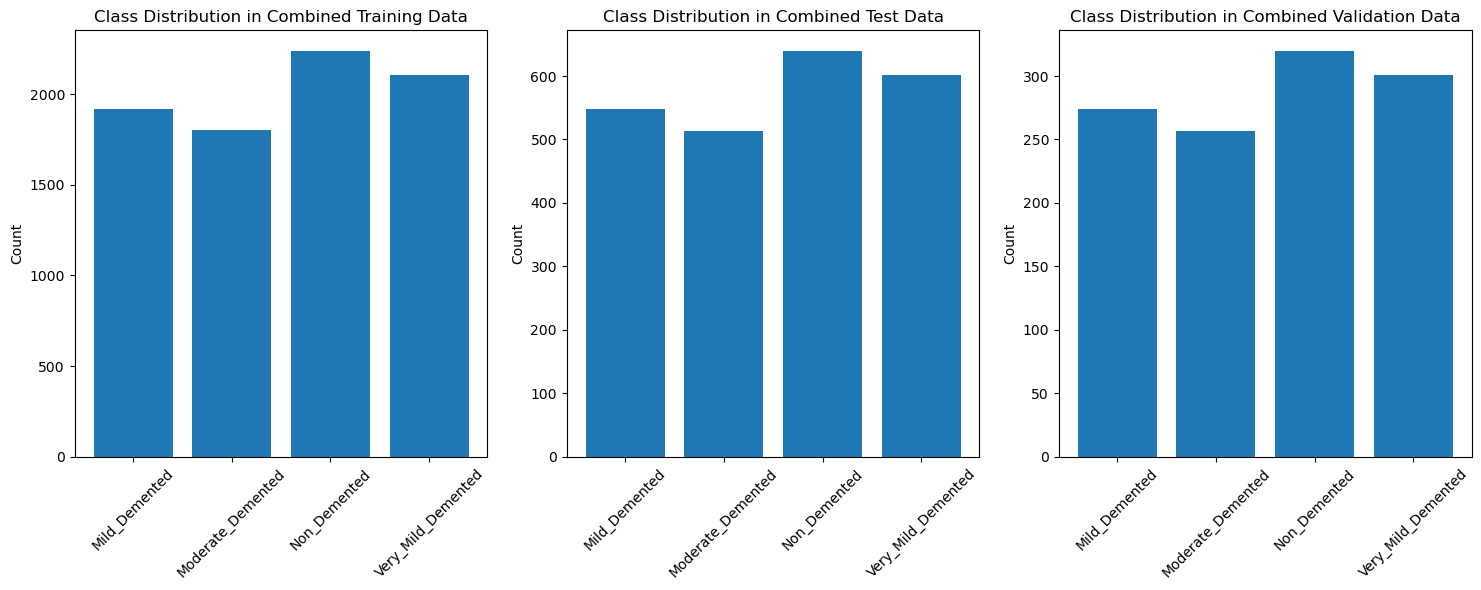

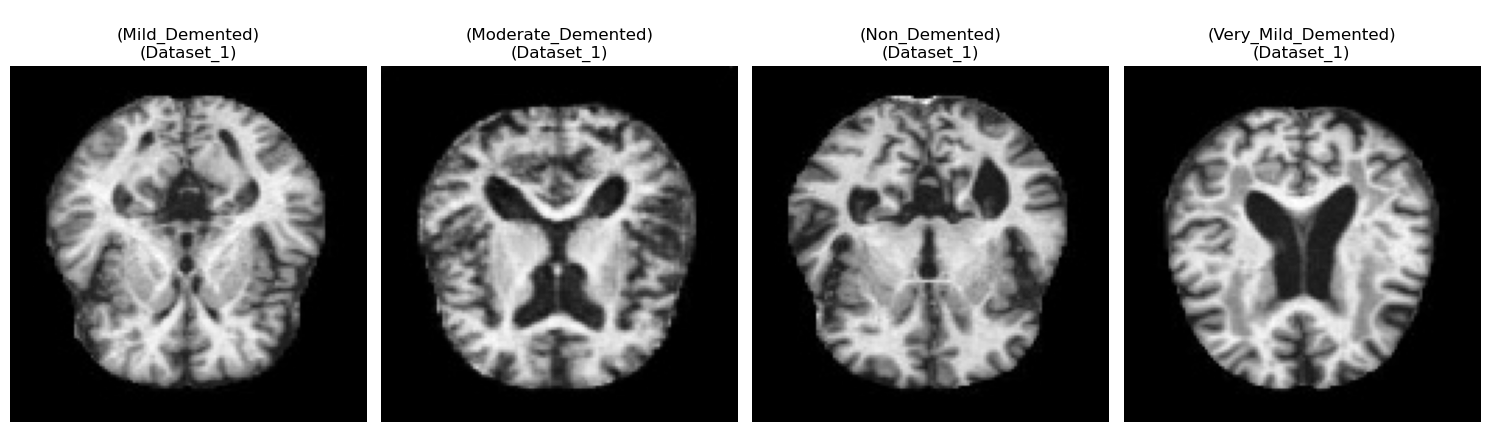

In [25]:
plot_class_distribution(resampled_train_data, resampled_test_data, resampled_val_data)
visualize_samples(resampled_train_data)

Part 2: Image processing

1) Calls feature_extraction_pipeline()

2) feature_extraction_pipeline(input_dir)
- Calls load_and_normalize_saved_dataset(input_dir) to load MRI images
- Calls visualize_normalizations(sample_data) to create visualization of normalization techniques
- Calls save_normalized_dataset(processed_output_dir, train_data, test_data, val_data) to save all normalized variants
- Calls save_processed_ventricle_images(train_data, test_data, val_data) to save the ventricle-focused images for training

3) load_and_normalize_saved_dataset(base_dir)
- Loads images from train, test, and val folders
- For each image, creates a data item with metadata
- Calls normalize_mri_for_ventricles(item) for each image
- Returns train, test, and val datasets separately

4) normalize_mri_for_ventricles(item)
- Performs intensity normalization on the image
- Creates enhanced version using CLAHE
- Creates inverted version to highlight ventricles
      - Inversion transforms the naturally dark ventricle regions in MRI scans into bright areas, making them stand out more prominently for better analysis of their shape and size
- Performs ventricle segmentation to create a mask
      - Ventricle segmentation creates a binary mask that isolates only the ventricle regions from the rest of the brain tissue, allowing the model to focus specifically on these structures which often enlarge during Alzheimer's progression.
- Returns the item with all processed variants added

5) save_normalized_dataset(base_dir, train_data, test_data, val_data)
- Creates output directories
- For each item in each dataset (train/test/val):
- Saves all normalized variants (normal, ventricle, enhanced, mask)

6) save_processed_ventricle_images(train_data, test_data, val_data, processed_dir)
- For each item in each dataset (train/test/val):
- Saves only the ventricle-focused images to designated folders for model training



In [29]:
import os
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

# Path for processed ventricle dataset - for model training
processed_output_dir = "Processed_MRI_Dataset"
os.makedirs(processed_output_dir, exist_ok=True)
os.makedirs(os.path.join(processed_output_dir, "train"), exist_ok=True)
os.makedirs(os.path.join(processed_output_dir, "test"), exist_ok=True)
os.makedirs(os.path.join(processed_output_dir, "val"), exist_ok=True)
os.makedirs(os.path.join(processed_output_dir, "models"), exist_ok=True)
os.makedirs(os.path.join(processed_output_dir, "plots"), exist_ok=True)

# Input path for resampled dataset
resampled_output_dir = "Resampled_MRI_Dataset"

# Class mapping
classes = {
    0: 'Mild_Demented',
    1: 'Moderate_Demented',
    2: 'Non_Demented',
    3: 'Very_Mild_Demented'
}

# Inverse class mapping for feature extraction
class_to_label = {
    'Mild_Demented': 0,
    'Moderate_Demented': 1,
    'Non_Demented': 2,
    'Very_Mild_Demented': 3
}

# Create class directories in processed output directory
for class_name in classes.values():
    os.makedirs(os.path.join(processed_output_dir, "train", class_name), exist_ok=True)
    os.makedirs(os.path.join(processed_output_dir, "test", class_name), exist_ok=True)
    os.makedirs(os.path.join(processed_output_dir, "val", class_name), exist_ok=True)

# Feature extraction and image normalization
def normalize_mri_for_ventricles(item):

    image = item['image']
    
    # 1. Intensity normalization (robust)
    '''
    https://www.frontiersin.org/journals/oncology/articles/10.3389/fonc.2025.1433444/full
    It mention why the treshold should be greater than 0.05
    '''
    
    brain_mask = image > 0.05
    brain_pixels = image[brain_mask] # exlcude the background pixel 
    
    if len(brain_pixels) > 0:
        p2, p98 = np.percentile(brain_pixels, [2, 98]) # eliminate outliers 
        normalized = np.clip(image, p2, p98) # p2 darker, p98 brighter 
        normalized = (normalized - p2) / (p98 - p2)
        item['image_normalized'] = normalized
    else:
        item['image_normalized'] = image
    
    # 2. Ventricle enhancement
    
    # convert to 8 bit form for processing 
    img_uint8 = (item['image_normalized'] * 255).astype(np.uint8)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(img_uint8)
    item['image_enhanced'] = enhanced / 255.0
    
    # makes dark regions bright and bright regions dark, make ventricles standout
    inverted = 1 - item['image_normalized']
    item['image_ventricle_focus'] = inverted
    
    # 3. Ventricle segmentation (rough approximation)
    # Threshold to isolate ventricles (dark regions)
    _, ventricle_mask = cv2.threshold(
        img_uint8, 
        int(np.mean(img_uint8) * 0.5), 
        255, 
        cv2.THRESH_BINARY_INV
    )
    
    # Clean up mask
    kernel = np.ones((3, 3), np.uint8)
    ventricle_mask = cv2.morphologyEx(ventricle_mask, cv2.MORPH_OPEN, kernel)
    ventricle_mask = cv2.morphologyEx(ventricle_mask, cv2.MORPH_CLOSE, kernel)
    
    item['ventricle_mask'] = ventricle_mask / 255.0
    
    return item

def visualize_normalizations(data, num_samples=4):
    # Select samples from each class if possible
    samples = []
    class_names = set(item['class_name'] for item in data)
    
    for class_name in class_names:
        class_items = [item for item in data if item['class_name'] == class_name]
        if class_items:
            samples.append(class_items[0])
            if len(samples) >= num_samples:
                break
    
    # Use random samples if we don't have enough
    if len(samples) < num_samples:
        additional = np.random.choice(
            [i for i in data if i not in samples],
            size=min(num_samples - len(samples), len(data) - len(samples)),
            replace=False
        ).tolist()
        samples.extend(additional)
    
    # Create visualization
    fig, axes = plt.subplots(len(samples), 4, figsize=(16, 4 * len(samples)))
    
    for i, item in enumerate(samples):
        # Original
        axes[i, 0].imshow(item['image'], cmap='gray')
        axes[i, 0].set_title(f"{item['class_name']}\nOriginal")
        axes[i, 0].axis('off')
        
        # Normalized
        axes[i, 1].imshow(item['image_normalized'], cmap='gray')
        axes[i, 1].set_title('Normalized')
        axes[i, 1].axis('off')
        
        # Enhanced
        axes[i, 2].imshow(item['image_enhanced'], cmap='gray')
        axes[i, 2].set_title('Enhanced')
        axes[i, 2].axis('off')
        
        # Ventricle Focus (Inverted)
        axes[i, 3].imshow(item['image_ventricle_focus'], cmap='gray')
        axes[i, 3].set_title('Ventricle Focus')
        axes[i, 3].axis('off')
    
    plt.tight_layout()
    return fig

def save_normalized_dataset(base_dir, train_data, test_data, val_data):
    """
    Save the normalized dataset with ventricle feature extraction
    """
    # Create output directories
    output_dir = os.path.join(base_dir, 'normalized')
    os.makedirs(output_dir, exist_ok=True)
    
    for split, data in [('train', train_data), ('test', test_data), ('val', val_data)]:
        split_dir = os.path.join(output_dir, split)
        os.makedirs(split_dir, exist_ok=True)
        
        # Create class directories
        class_names = set(item['class_name'] for item in data)
        for class_name in class_names:
            os.makedirs(os.path.join(split_dir, class_name), exist_ok=True)
        
        # Save normalized images
        for item in tqdm(data, desc=f"Saving {split} images"):
            # Generate filename
            if item['source'] == 'folder_dataset':
                original_filename = os.path.basename(item['original_path'])
            else:
                original_filename = f"parquet_{item['class_name']}_{id(item)}.png"
                
            base_name = os.path.splitext(original_filename)[0]
            
            # Define paths for different normalizations
            class_dir = os.path.join(split_dir, item['class_name'])
            
            # Save normalized image
            norm_img = (item['image_normalized'] * 255).astype(np.uint8)
            norm_path = os.path.join(class_dir, f"{base_name}_norm.png")
            Image.fromarray(norm_img).save(norm_path)
            
            # Save ventricle focused image (better for ventricle analysis)
            ventricle_img = (item['image_ventricle_focus'] * 255).astype(np.uint8)
            ventricle_path = os.path.join(class_dir, f"{base_name}_ventricle.png")
            Image.fromarray(ventricle_img).save(ventricle_path)
            
            # Save enhanced image
            enhanced_img = (item['image_enhanced'] * 255).astype(np.uint8)
            enhanced_path = os.path.join(class_dir, f"{base_name}_enhanced.png")
            Image.fromarray(enhanced_img).save(enhanced_path)
            
            # Save ventricle mask
            mask_img = (item['ventricle_mask'] * 255).astype(np.uint8)
            mask_path = os.path.join(class_dir, f"{base_name}_mask.png")
            Image.fromarray(mask_img).save(mask_path)

# Save processed images to the specific processed directory for training
def save_processed_ventricle_images(train_data, test_data, val_data, processed_dir=processed_output_dir):
    """
    Save the ventricle-focused images to the processed directory for model training
    """
    for split, data in [('train', train_data), ('test', test_data), ('val', val_data)]:
        for item in tqdm(data, desc=f"Saving {split} processed images"):
            # Generate filename
            if item['source'] == 'folder_dataset':
                original_filename = os.path.basename(item['original_path'])
            else:
                original_filename = f"parquet_{item['class_name']}_{id(item)}.png"
                
            base_name = os.path.splitext(original_filename)[0]
            
            # Define paths for ventricle images
            class_dir = os.path.join(processed_dir, split, item['class_name'])
            os.makedirs(class_dir, exist_ok=True)
            
            # Save ventricle focused image for training
            ventricle_img = (item['image_ventricle_focus'] * 255).astype(np.uint8)
            ventricle_path = os.path.join(class_dir, f"{base_name}_ventricle.png")
            Image.fromarray(ventricle_img).save(ventricle_path)

# Apply feature extraction to dataset
def process_with_feature_extraction(data):
    processed_data = []
    
    for item in tqdm(data, desc="Applying feature extraction"):
        processed_item = normalize_mri_for_ventricles(item)
        processed_data.append(processed_item)
    
    return processed_data

def load_and_normalize_saved_dataset(base_dir):
    """
    Load a previously saved dataset and apply normalization
    """
    normalized_data = []
    
    # Process train, test, and val folders
    for split in ['train', 'test', 'val']:
        split_dir = os.path.join(base_dir, split)
        
        if not os.path.exists(split_dir):
            print(f"Warning: {split_dir} does not exist, skipping...")
            continue
        
        # Process each class folder
        for class_name, label in class_to_label.items():
            class_dir = os.path.join(split_dir, class_name)
            
            if not os.path.exists(class_dir):
                continue
                
            # Process each image in the class folder
            for img_file in os.listdir(class_dir):
                if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    img_path = os.path.join(class_dir, img_file)
                    
                    try:
                        # Load image
                        img = Image.open(img_path).convert('L')
                        img_array = np.array(img) / 255.0  # Normalize to [0,1]
                        
                        # Process and store
                        item = {
                            'original_path': img_path,
                            'label': label,
                            'class_name': class_name,
                            'split': split,
                            'image': img_array,
                            'source': 'folder_dataset' if 'folder' in img_file else 'parquet_dataset'
                        }
                        
                        # Apply normalizations
                        normalized_item = normalize_mri_for_ventricles(item)
                        normalized_data.append(normalized_item)
                        
                    except Exception as e:
                        print(f"Error processing {img_path}: {e}")
    
    # Split back into train, test, and val
    train_data = [item for item in normalized_data if item['split'] == 'train']
    test_data = [item for item in normalized_data if item['split'] == 'test']
    val_data = [item for item in normalized_data if item['split'] == 'val']
    
    return train_data, test_data, val_data

def feature_extraction_pipeline(input_dir=resampled_output_dir):
    """
    Apply feature extraction to already combined and resampled data
    """
    print("Starting feature extraction pipeline...")
    
    # Option 1: Load from saved images and then process
    print("\nLoading resampled data for processing...")
    train_data, test_data, val_data = load_and_normalize_saved_dataset(input_dir)
    print(f"Loaded {len(train_data)} training, {len(test_data)} test, and {len(val_data)} validation images")


    # Step 1: Visualize normalizations
    print("\nGenerating normalization visualization...")
    sample_data = train_data[:2] + test_data[:1] + val_data[:1]  # Take samples from each set
    fig = visualize_normalizations(sample_data)
    plt.savefig(os.path.join(processed_output_dir, "normalization_visualization.png"))
    plt.close(fig)

    # Step 2: Save all normalized variants to the normalized subfolder
    print("\nSaving complete normalized dataset with all variants...")
    save_normalized_dataset(processed_output_dir, train_data, test_data, val_data)

    # Step 3: Save only the ventricle-focused images for training
    print("\nSaving ventricle-focused images for model training...")
    save_processed_ventricle_images(train_data, test_data, val_data)
    
    print("\nFeature extraction complete! Data is ready for model training.")
    print(f"Processed data saved to {processed_output_dir}")
    
    return train_data, test_data, val_data


In [ ]:
feature_extraction_pipeline()

Starting feature extraction pipeline...

Loading resampled data for processing...
Loaded 8063 training, 2304 test, and 1152 validation images

Generating normalization visualization...

Saving complete normalized dataset with all variants...


Saving train images:  65%|███████████      | 5220/8063 [00:07<00:04, 698.14it/s]